<a href="https://colab.research.google.com/github/mikeguzman1294/DPP4GA4SRMP4MCDA/blob/kendall-tau/dpp_dm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DPP test on 100 DM

In this notebook we compute dpp on 100 decison makers, plot them and the selected sample using the kendall index 

In [ ]:
import numpy 
import matplotlib.pyplot as pyplot
from numpy.random import rand, randn, RandomState
from scipy.linalg import qr
from dppy.finite_dpps import FiniteDPP
import pandas as pd
import os

### Import existing building functions

In [ ]:
def create_blank_decision_maker () :

    ###########################################################################################################
    """
        Creates a blank decision maker.
        --
        In:
            * None.
        Out:
            * decision_maker: Created decision maker, formatted as a dictionary, with only ID set.
    """
    ###########################################################################################################

    # We add a unique id to the decision maker
    global decision_maker_ids_counter
    if "decision_maker_ids_counter" not in globals() :
        decision_maker_ids_counter = 0
    else :
        decision_maker_ids_counter += 1

    # Let's create the object
    decision_maker = {"weights": None,
                      "profiles": None,
                      "order": None,
                      "id": decision_maker_ids_counter}
    
    # Done
    return decision_maker

In [ ]:
def correct_decision_maker (decision_maker) :

    ###########################################################################################################
    """
        Corrects a decision maker.
        --
        In:
            * decision_maker: Decision maker to correct.
        Out:
            * None.
    """
    ###########################################################################################################

    # Profiles in [0, 1] and sorted
    decision_maker["profiles"][decision_maker["profiles"] < 0.0] = 0.0
    decision_maker["profiles"][decision_maker["profiles"] > 1.0] = 1.0
    decision_maker["profiles"] = -numpy.sort(-decision_maker["profiles"], axis=0)
    
    # Weights in ]0, 1] and with 1-sum
    nb_criteria = decision_maker["profiles"].shape[1]
    decision_maker["weights"][decision_maker["weights"] < 0.0] = 1.0 / nb_criteria
    decision_maker["weights"][decision_maker["weights"] > 1.0] = 1.0
    decision_maker["weights"] /= numpy.sum(decision_maker["weights"])

In [ ]:
def create_random_decision_maker (nb_criteria, nb_profiles) :

    ###########################################################################################################
    """
        Creates a random decision maker.
        --
        In:
            * nb_criteria: Number of criteria.
            * nb_profiles: Number of profiles to generate.
        Out:
            * decision_maker: Randomly created decision maker, formatted as a dictionary.
    """
    ###########################################################################################################

    # Random weights and profiles
    decision_maker = create_blank_decision_maker()
    decision_maker["weights"] = numpy.random.rand(nb_criteria)
    decision_maker["profiles"] = numpy.random.uniform(0.0, 1.0, (nb_profiles, nb_criteria))
    correct_decision_maker(decision_maker)
    
    # We choose an order for the profiles
    order = numpy.array(range(nb_profiles))
    numpy.random.shuffle(order)
    decision_maker["order"] = order

    # Done
    return decision_maker

In [ ]:
def create_directory_for (file_name) :

    ###########################################################################################################
    """
        Creates the directory for the given file name if it does not exist.
        --
        In:
            * file_name: Directory to create, or file for which we want to create a directory.
        Out:
            * None.
    """
    ###########################################################################################################

    # Creates the corresponding directory
    dir_name = os.path.dirname(file_name)
    os.makedirs(dir_name, exist_ok=True)

In [ ]:
def plot_decision_maker (decision_maker, alternatives=[], title="", file_name=None) :

    ###########################################################################################################
    """
        Plots a decision maker.
        --
        In:
            * decision_maker: Decision maker to plot.
            * alternatives: List of alternatives to plot with the decision maker.
            * title: Complementary information to plot in the title.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################

    # Vertical bars
    figure = pyplot.figure(figsize=(20, 10))
    nb_criteria = decision_maker["profiles"].shape[1]
    for i in range(nb_criteria) :
        pyplot.plot([i, i], [0, 1], "k")

    # Profiles
    nb_profiles = decision_maker["profiles"].shape[0]
    for i in range(nb_profiles) :
        plotted = pyplot.plot(range(nb_criteria), decision_maker["profiles"][i], ":*")
        pyplot.text(-0.02 * nb_criteria, decision_maker["profiles"][i][0], "p" + str(i), color=plotted[-1].get_color())
        pyplot.text(nb_criteria - 1 + 0.01 * nb_criteria, decision_maker["profiles"][i][-1], "p" + str(i), color=plotted[-1].get_color())
    
    # Alternatives
    for alternative in alternatives :
        plotted = pyplot.plot(range(nb_criteria), alternative["profile"], "-*", label=alternative["id"])
        pyplot.text(-0.02 * nb_criteria, alternative["profile"][0], "a" + str(alternative["id"]), color=plotted[-1].get_color())
        pyplot.text(nb_criteria - 1 + 0.01 * nb_criteria, alternative["profile"][-1], "a" + str(alternative["id"]), color=plotted[-1].get_color())
    
    # Plot decorations
    pyplot.xticks(range(nb_criteria), ["w" + str(i) + " =\n" + str(decision_maker["weights"][i]) for i in range(nb_criteria)], rotation=45)
    pyplot.yticks([0, 1])
    figure.gca().set_frame_on(False)
    pyplot.tight_layout()
    pyplot.title("dm" + str(decision_maker["id"]) + "\n" + " -> ".join("p" + str(o) for o in decision_maker["order"]) + ("\n" + title if title != "" else ""))
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [ ]:
def create_random_alternative (nb_criteria) :

    ###########################################################################################################
    """
        Creates a random alternative.
        --
        In:
            * nb_criteria: Number of criteria.
        Out:
            * alternative: Created alternative, formatted as a dictionary.
    """
    ###########################################################################################################

    # An alternative is a profile
    profile = numpy.random.uniform(0.0, 1.0, nb_criteria)

    # We add a unique id to the alternative
    global alternative_ids_counter
    if "alternative_ids_counter" not in globals() :
        alternative_ids_counter = 0
    else :
        alternative_ids_counter += 1

    # Let's create the alternative
    alternative = {"profile": profile,
                   "id": alternative_ids_counter}

    # Done
    return alternative

In [ ]:
def compute_concordance (decision_maker, discriminating_profile, alternative) :

    ###########################################################################################################
    """
        Returns the concordance of an alternative with respect to a reference profile.
        --
        In:
            * decision_maker: Reference decision maker used to compute concordance of the alternative.
            * discriminating_profile: Number of the profile to use in the decision maker's profiles.
            * alternative: Alternative for which we want to compute concordance.
        Out:
            * result: Concordance for the alternative.
    """
    ###########################################################################################################

    # Sum of weights for all criteria above discriminating profile
    result = numpy.dot(alternative["profile"] >= decision_maker["profiles"][discriminating_profile], decision_maker["weights"].transpose())
    
    # Done
    return result

In [ ]:
def check_preference (decision_maker, alternative_1, alternative_2) :

    ###########################################################################################################
    """
        Check which is preferred between two alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternative_1: First alternative to compare.
            * alternative_2: Second alternative to compare.
        Out:
            * preferred: Alternative in {alternative_1, alternative_2} which is preferred, or None if there is no preference.
            * discriminating_profile: Profile used in the decision maker to determine preference, or None if there is no preference.
    """
    ###########################################################################################################

    # Default value if no alternative is preferred to the other
    preferred, discriminating_profile = None, None
    
    # We check preferred profiles in the given order
    for i in decision_maker["order"] :
        alternative_1_concordance = compute_concordance(decision_maker, i, alternative_1)
        alternative_2_concordance = compute_concordance(decision_maker, i, alternative_2)
        if alternative_1_concordance > alternative_2_concordance :
            return alternative_1, i
        elif alternative_1_concordance < alternative_2_concordance :
            return alternative_2, i
    
    # Done
    return preferred, discriminating_profile

In [ ]:
def compute_all_preferences (decision_maker, alternatives) :

    ###########################################################################################################
    """
        Checks all preference relations among alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternatives: List of alternatives to compare.
        Out:
            * discriminating_profiles: Matrix (sorted in increasing IDs) of profiles used in the decision maker to determine dominance, with -1 entries if there is no dominance.
            * preferences: Matrix (sorted in increasing IDs) of dominances, where result_dominances[i][j] == 1 if alternative i dominates alternative j, -1 if there is no dominance, and 0 otherwise.
    """
    ###########################################################################################################
    
    # Alternatives are sorted in increasing ID for the matrix
    sorted_alternatives = sorted(alternatives, key=lambda obj : obj["id"])
    nb_alternatives = len(sorted_alternatives)
    
    # We return a matrix indicating which profile is used for determining preference, and another indicating which alternative is preferred
    discriminating_profiles = numpy.zeros((nb_alternatives, nb_alternatives)) - 1
    preferences = numpy.zeros((nb_alternatives, nb_alternatives)) - 1
    
    # We check all pairs
    for alternative_1 in range(nb_alternatives) :
        for alternative_2 in range(alternative_1 + 1, nb_alternatives) :
            preferred, discriminating_profile = check_preference(decision_maker, sorted_alternatives[alternative_1], sorted_alternatives[alternative_2])
            if preferred is not None :
                discriminating_profiles[alternative_1, alternative_2] = discriminating_profile
                discriminating_profiles[alternative_2, alternative_1] = discriminating_profiles[alternative_1, alternative_2]
                preferences[alternative_1, alternative_2] = int(preferred["id"] == alternatives[alternative_1]["id"])
                preferences[alternative_2, alternative_1] = 1 - preferences[alternative_1, alternative_2]
    
    # Done
    return discriminating_profiles, preferences

### Generate the data (decision makers and alternatives) using existing functions

In [ ]:
nb_criteria = 7
nb_profiles = 3
nb_alternatives = 100 
nb_dm = 500
decision_makers = [create_random_decision_maker(nb_criteria, nb_profiles) for i in range(nb_dm)]
alternatives = [create_random_alternative(nb_criteria) for i in range(nb_alternatives)]

### Plot them in a two dimensional space
We plot them according to the kendall tau that is calculated thanks to their alternatives classment  

Calculation by hand using its formula  
https://fr.wikipedia.org/wiki/Tau_de_Kendall  



In [ ]:
preferences_dms = []
for i in range (nb_dm):
    discriminating_profiles, preferences = compute_all_preferences(decision_makers[i], alternatives)
    preferences_dms.append(preferences)


In [ ]:
def k_calculation(preferences):
    k_tau_dm = numpy.ones((nb_dm,nb_dm))
    for k in range(nb_dm):
        for l in range(k+1,nb_dm):
            dissimilarities = preferences_dms[k]-preferences_dms[l]
            matching_pairs = 0 
            conflicting_pairs = 0
            for i in range(1,nb_alternatives):
                for j in range(i,nb_alternatives):
                    if abs(dissimilarities[i,j])==1 : # if the substraction is 1 or -1 their a different classification
                        conflicting_pairs += 1
                    elif dissimilarities[i,j]==0 : # and if it is 2 or -2 it means that one of the alternatives has not been treated
                        matching_pairs += 1
            k_tau_dm[k,l] = 2*(matching_pairs - conflicting_pairs)/nb_alternatives/(nb_alternatives-1)
            k_tau_dm[l,k] = 2*(matching_pairs - conflicting_pairs)/nb_alternatives/(nb_alternatives-1)

    return k_tau_dm


In [ ]:
# juste calculating the dissimilarity between the 2 dm

def dis_calculation(preferences):
    dis_dm = numpy.ones((nb_dm,nb_dm))
    for k in range(nb_dm):
        for l in range(k+1,nb_dm):
            dissimilarities = preferences_dms[k]-preferences_dms[l]
            matching_pairs = 0 
            conflicting_pairs = 0
            for i in range(1,nb_alternatives):
                for j in range(i,nb_alternatives):
                    if abs(dissimilarities[i,j])==1 : # if the substraction is 1 or -1 their a different classification
                        conflicting_pairs += 1
                    elif dissimilarities[i,j]==0 : # and if it is 2 or -2 it means that one of the alternatives has not been treated
                        matching_pairs += 1
            dis_dm[k,l] = conflicting_pairs/(matching_pairs+conflicting_pairs)
            dis_dm[l,k] = conflicting_pairs/(matching_pairs+conflicting_pairs)

    return dis_dm


In [ ]:
k_tau_dm = k_calculation(preferences_dms)

In [ ]:
# with sicpy
# we need to implement a function that gives the order of the alternatives to put it as the entrance

To represent them in 2D, we should reduce the dimension  
-> by implementing a t-SNE on the distance we calculates (and may be a PCA before to reduce the dimension at approximatly 50 because t-SNE doesn't work well on high dim)

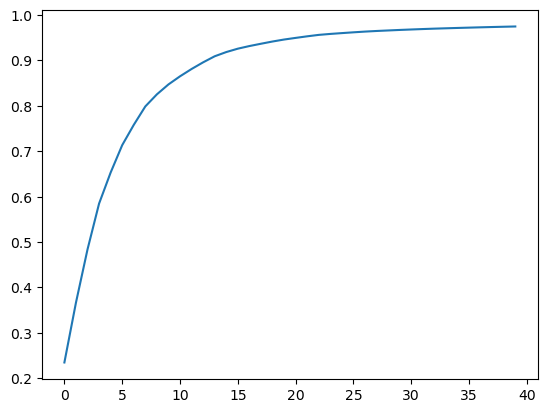

In [ ]:
from sklearn.decomposition import PCA
n = 40
pca = PCA(n_components=n)
dm_encoded = pca.fit_transform(k_tau_dm)

count = [i for i in range(n)]
pyplot.plot(count,numpy.cumsum(pca.explained_variance_ratio_))

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,init='random',learning_rate='auto')
dm_2D = tsne.fit_transform(dm_encoded)
dm_2D.shape

(500, 2)

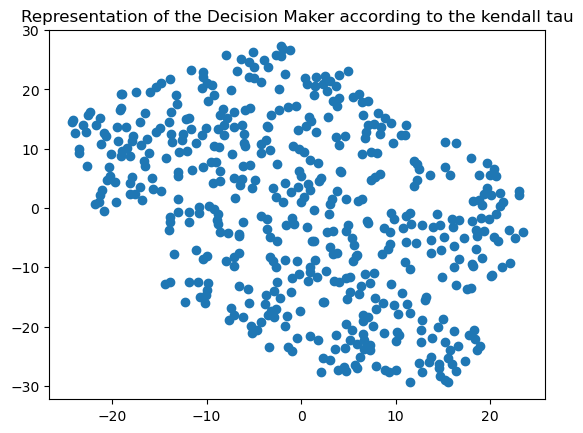

In [ ]:
# plot dm
pyplot.scatter(dm_2D[:,0],dm_2D[:,1])
pyplot.title('Representation of the Decision Maker according to the kendall tau')
pyplot.show()

### Encode each of them into a single vector
Building the entrance of DPP

In [ ]:
decision_makers[0]

{'weights': array([0.204542  , 0.23721967, 0.0192329 , 0.02234901, 0.2101072 ,
        0.17538243, 0.13116678]),
 'profiles': array([[0.50643718, 0.90963806, 0.63659056, 0.77659723, 0.90773899,
         0.78788923, 0.98325976],
        [0.45638247, 0.9023271 , 0.60700935, 0.18988353, 0.67590914,
         0.67106831, 0.89017827],
        [0.11749077, 0.72742876, 0.04614404, 0.0851585 , 0.43779472,
         0.44506938, 0.41118786]]),
 'order': array([1, 2, 0]),
 'id': 100}

Scaling the weights so that they won't be dominated by the profiles  


In [ ]:
#creation of the vector : to be improved
dm_vectors = [numpy.concatenate((decision_makers[i]['weights'],
                numpy.concatenate([decision_makers[i]['profiles'][j] for j in range(nb_profiles)]))) 
                for i in range(nb_dm)]

### Compute DPP and plot the retained sample

In [ ]:
from pydpp.dpp import DPP
import scipy as sp

In [ ]:
dpp = DPP(dm_vectors)
dpp.compute_kernel(kernel_type = 'rbf', sigma= 0.4)

In [ ]:
sample_size = 10

idx = dpp.sample_k(sample_size)
sample = dm_2D[idx]

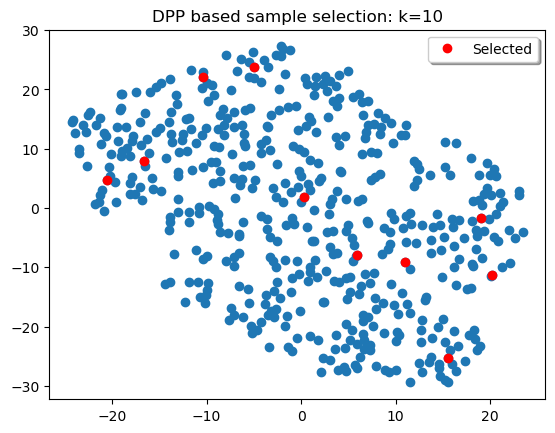

In [ ]:
fig, ax = pyplot.subplots()
ax.plot(dm_2D[:,0], dm_2D[:,1], 'o', label='')
ax.plot(sample[:,0], sample[:,1], 'ro', label='Selected')
ax.set_title('DPP based sample selection: k=10')

legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')


## Evaluating the relevance of dpp sampling
Look at the dm choosen and compare the method to a random sampling

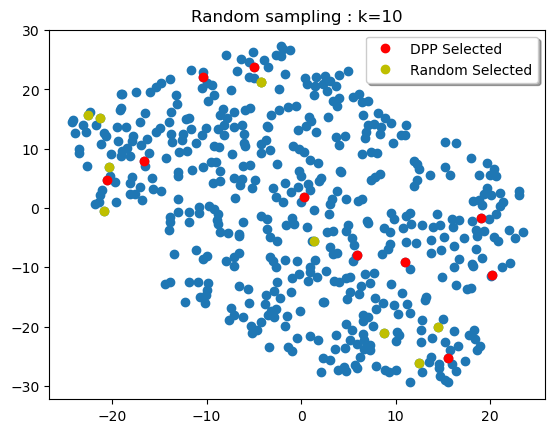

In [ ]:
rand_idx = [numpy.random.randint(0,nb_dm) for _ in range(sample_size)]
rand_dm = dm_2D[rand_idx]

fig, ax = pyplot.subplots()
ax.plot(dm_2D[:,0], dm_2D[:,1], 'o', label='')
ax.plot(sample[:,0], sample[:,1], 'ro', label='DPP Selected')
ax.plot(rand_dm[:,0], rand_dm[:,1], 'yo', label='Random Selected')
ax.set_title('Random sampling : k=10')

legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')
